In [1]:
# Import packages 
import sys
import argparse as arg

import time
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# import modules in other directories
sys.path.append('../Regridder/')
import scripGen as SG
sys.path.append('../Utils/')
import VertGridUtils as VGU

import importlib
importlib.reload( SG )
importlib.reload( VGU )

#Rdry = Con.Rdry() # 



 MyConstants in /glade/work/juliob/PyRegridding/Utils 


<module 'VertGridUtils' from '/glade/work/juliob/PyRegridding/Drivers/../Utils/VertGridUtils.py'>

 given by

p(\eta) = A(\eta) p_0 + B(\eta) p_s.

In [2]:
#####################################
myGridFiles = '/glade/work/juliob/GridFiles/'


In [7]:

LWaf='/glade/campaign/cesm/cesmdata/cseg/inputdata/atm/waccm/ic/FW2000_ne30pg3_L70_01-01-0001_c200602.nc'

L58f = f'{myGridFiles}/Vertical/GRID_48_taperstart10km_lowtop_BL10_v3p1_beta1p75.nc'
L93f = f'{myGridFiles}/Vertical/GRID_93L_CAM7_OrigAB_c20240514.nc'


In [8]:
L58=xr.open_dataset( L58f )
L93=xr.open_dataset( L93f )
LWa=xr.open_dataset( LWaf )

p58 = L58.hyai.values + L58.hybi.values
p93 = L93.hyai.values + L93.hybi.values
pWa = LWa.hyai.values + LWa.hybi.values


In [ ]:
hyaiXX , hybiXX = VGU.Original_as_bs(pXX , gridalign=True, p58=p58 )

Text(0.5, 1.0, '$\\mathrm{hybrid}~~A(\\eta)~~\\mathrm{and}~~B(\\eta)$')

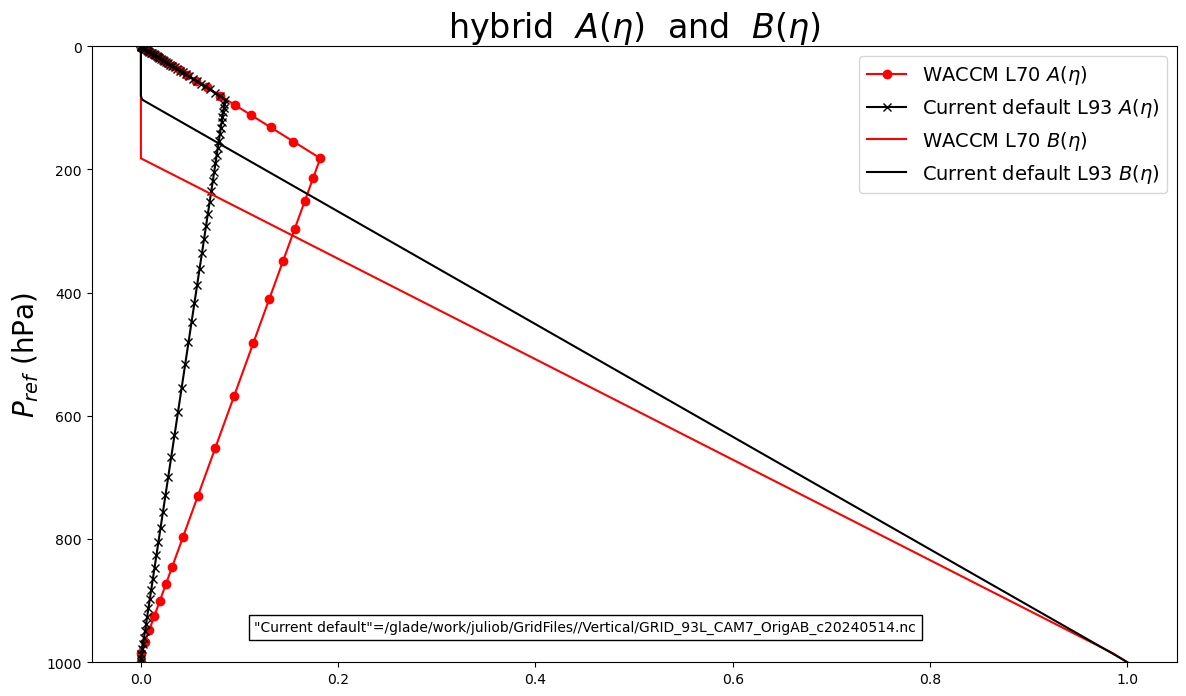

In [9]:

fig,ax=plt.subplots( 1,1 , squeeze=False, figsize=(14,8) )

ax[0,0].plot(LWa.hyai  , 1_000.*pWa, '-o' ,color='red'  , label='WACCM L70 $A(\eta)$' )
ax[0,0].plot(L93.hyai , 1_000.*p93 ,'-x', color='black' , label='Current default L93 $A(\eta)$'   )
ax[0,0].plot(LWa.hybi  , 1_000.*pWa ,color='red' , label='WACCM L70 $B(\eta)$'  )
ax[0,0].plot(L93.hybi , 1_000.*p93, color='black' , label='Current default L93 $B(\eta)$'   )

annot3= ax[0,0].text( 0.15,.05,f'"Current default"={L93f}' , transform=ax[0,0].transAxes, fontsize=10, bbox=dict(facecolor='white') )

plt.ylim( (1000.,0.) )
plt.legend(fontsize=14)
plt.ylabel( "$P_{ref}$ (hPa)" ,fontsize=20)
plt.title( "$\mathrm{hybrid}~~A(\eta)~~\mathrm{and}~~B(\eta)$", fontsize=24 )

In [30]:
print(100_000.*p93[0])
print(100_000.*pWa[0])
print( len(pWa))
mask = (pWa < p93[0] )
print(mask)
print(np.where(mask==True))
ktrunc=14
print(100_000.*pWa[ktrunc])
print(100_000.*pWa[ktrunc:])
pXX = pWa[ktrunc:]
hyaiXX=LWa.hyai.values[ktrunc:]
hybiXX=LWa.hybi.values[ktrunc:]
zXX = -7_000. * np.log( pXX/1. )
z93 = -7_000. * np.log( p93/1. )
print(max(zXX))
print(max(z93))


0.42587711019659924
0.0004500499972692751
71
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False]
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),)
0.49629998102318496
[4.96299981e-01 8.15065141e-01 1.34769998e+00 2.23190000e+00
 3.67965004e+00 6.06649992e+00 9.91565030e+00 1.57389994e+01
 2.38850000e+01 3.45200009e+01 4.75134992e+01 6.31804985e+01
 8.29154975e+01 1.08274003e+02 1.40684994e+02 1.81885005e+02
 2.33979989e+02 2.99505005e+02 3.81470006e+02 4.83444985e+02
 6.09635003e+02 7.64934998e+02 9.55010019e+02 1.18640000e+03
 1.46655003e+03 1.80380009e+03 2.20755003e+03 2.68824995e+03
 3.25734

In [31]:
nzXXe  =len(pXX)
nzXX   =nzXXe-1


hyamXX = np.zeros( nzXX )
hybmXX = np.zeros( nzXX )

for L in np.arange( 0, nzXX, 1):
    hyamXX[L] = 0.5 * ( hyaiXX[L] + hyaiXX[L+1] )
    hybmXX[L] = 0.5 * ( hybiXX[L] + hybiXX[L+1] ) 


In [34]:
import datetime
# Using the current date
current_date = datetime.datetime.now()
create_date = current_date.strftime('c%Y%m%d')
topkm=max(z93)/1000.
desc=f'TruncatedWACCM-Top{int(topkm):2d}km' #'OrigAB'


ilev = (hyaiXX + hybiXX ) * 1_000. #* 100_000.
lev  = (hyamXX + hybmXX ) * 1_000. #* 100_000.


dims   = ["lev","ilev"]
coords = dict( 
    lev  = ( ["lev"],lev),
    ilev = ( ["ilev"],ilev),
)


NewVgrid = xr.Dataset( coords=coords  )

Dar = xr.DataArray( data=hyaiXX, dims=('ilev',),
                    attrs=dict( description='interface hybrid eta coordinate A-coeff ',units='1',) ,) 
NewVgrid['hyai'] = Dar

Dar = xr.DataArray( data=hybiXX, dims=('ilev',),
                    attrs=dict( description='interface hybrid eta coordinate B-coeff ',units='1',) ,) 
NewVgrid['hybi'] = Dar

Dar = xr.DataArray( data=hyamXX, dims=('lev',),
                    attrs=dict( description='mid-level hybrid eta coordinate A-coeff ',units='1',) ,) 
NewVgrid['hyam'] = Dar

Dar = xr.DataArray( data=hybmXX, dims=('lev',),
                    attrs=dict( description='mid-level hybrid eta coordinate B-coeff ',units='1',) ,) 
NewVgrid['hybm'] = Dar

newname = f'{myGridFiles}/Vertical/GRID_{str(nzXX)}L_CAM7_{desc}_{create_date}.nc'

print(newname) 

/glade/work/juliob/GridFiles//Vertical/GRID_56L_CAM7_TruncatedWACCM-Top86km_c20240705.nc


In [35]:
NewVgrid.to_netcdf( newname )

In [ ]:
import copy
L135new= copy.deepcopy( L135 )

In [ ]:

L135new['ilev']=NewVgrid['ilev']
L135new['lev']=NewVgrid['lev']
L135new['hyai']=NewVgrid['hyai']
L135new['hybi']=NewVgrid['hybi']
L135new['hyam']=NewVgrid['hyam']
L135new['hybm']=NewVgrid['hybm']



In [ ]:

L135fnew = '/glade/work/juliob/f.e23.FWmaHIST.ne16pg3_mg17_L135_c240604_tag119fvitt_beres0.6.cam.i.2001-01-01-00000.nc'
L135new.to_netcdf( L135fnew )

In [ ]:


print( np.min( dzXX[40:70] ) )

fig,ax=plt.subplots( 1,3, squeeze=False, figsize=(20,8)  )

j,i=0,0
psfc = 1_000.
pXX_ev = 1_000. * hyaiXX   + psfc * hybiXX
p93_ev = 1_000. * L93.hyai.values   + psfc * L93.hybi.values
z93_ev = -7_000. * np.log( p93_ev/1_000. )
zXX_ev = -7_000. * np.log( pXX_ev/1_000. )

dz93 = -( z93_ev[1:94]-z93_ev[0:93]  )
dzXX = -( zXX_ev[1:94]-zXX_ev[0:93] )

ax[j,i].plot( dzXX , z93_ev[0:93]) #pXX_ev )
ax[j,i].plot( dz93, zXX_ev[0:93] ,'--' ) # p93_ev )
ax[j,i].set_ylim(0,40_000)
ax[j,i].set_xlim(-300,3_000)
ax[j,i].set_xlabel( '$\Delta z$ (m)' , fontsize=20)
ax[j,i].set_ylabel( '$z$ (m)' , fontsize=20)
ax[j,i].set_title( 'Ocean - 1000 hPa ',fontsize=20)

j,i=0,1
psfc = 400.
pXX_ev = 1_000. * hyaiXX   + psfc * hybiXX
p93_ev = 1_000. * L93.hyai.values   + psfc * L93.hybi.values
z93_ev = -7_000. * np.log( p93_ev/1_000. )
zXX_ev = -7_000. * np.log( pXX_ev/1_000. )

dz93 = -( z93_ev[1:94]-z93_ev[0:93]  )
dzXX = -( zXX_ev[1:94]-zXX_ev[0:93] )

ax[j,i].plot( dzXX , zXX_ev[0:93]) #pXX_ev )
ax[j,i].plot( dz93, z93_ev[0:93] , '--') # p93_ev )
ax[j,i].plot( [0,0] , [0,50_000] ,':' ) # p93_ev )
ax[j,i].set_ylim(0,40_000)
ax[j,i].set_xlim(-300,3_000)
ax[j,i].set_xlabel( '$\Delta z$ (m)' , fontsize=20)
#ax[j,i].set_ylabel( '$z$ (m)' , fontsize=20)
ax[j,i].set_title( '"Everest/Chomolungma" - 400 hPa ',fontsize=20)

j,i=0,2
psfc = 520.
pXX_ev = 1_000. * hyaiXX   + psfc * hybiXX
p93_ev = 1_000. * L93.hyai.values   + psfc * L93.hybi.values
z93_ev = -7_000. * np.log( p93_ev/1_000. )
zXX_ev = -7_000. * np.log( pXX_ev/1_000. )

dz93 = -( z93_ev[1:94]-z93_ev[0:93]  )
dzXX = -( zXX_ev[1:94]-zXX_ev[0:93] )

ax[j,i].plot( dzXX, zXX_ev[0:93] ,label='New L93' ) # p93_ev )
ax[j,i].plot( dz93 , z93_ev[0:93],'--',label='Current L93' ) #pXX_ev )
ax[j,i].plot( [0,0] , [0,50_000] ,':' ) # p93_ev )
ax[j,i].set_ylim(0,40_000)
ax[j,i].set_xlim(-300,3_000)
ax[j,i].set_xlabel( '$\Delta z$ (m)' , fontsize=20)
#ax[j,i].set_ylabel( '$z$ (m)' , fontsize=20)
ax[j,i].set_title( 'Highest point at ne30 - 520 hPa ',fontsize=20)

plt.legend()

In [ ]:
print(pXX[92])


hooiii=-0.095  * pXX + 0.095 * pXX[92]

print( hooiii[-40:])
print( L93.hyai.values[-40:])
print( L93.hyai.values[-40:]-hooiii[-40:] )



In [ ]:

plt.plot(L58.hyai[-57:],'o')
plt.plot(L93.hyai[-57:],'x')
plt.plot(L93.hyai[-57:].values-L58.hyai[-57:].values)


In [ ]:
fig,ax=plt.subplots(1, 2, squeeze=False) 
ax[0,0].plot( L58.hybi ,z58,'-o')
ax[0,0].plot( L58.hyai ,z58)
ax[0,0].plot( L32.hybi ,z32,'-x')
ax[0,0].plot( L32.hyai ,z32)
ax[0,0].plot( hyaiXX ,zXX)
ax[0,0].plot( hybiXX ,zXX,'-+')

ax[0,1].plot( dz58,zo58,'-o')
ax[0,1].plot( dz32,zo32,'-x')
ax[0,1].plot( dzXX,zoXX,'-+')


In [ ]:
print(newname)